In [1]:
import numpy as np
import pandas as pd
import sklearn
import json
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from scipy.stats import pearsonr
from scipy import stats

#estimators
from sklearn.linear_model import LinearRegression, Ridge, Lasso

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore")

plt.rcParams.update({'font.size':14})



# Read data

In [2]:
df_diesel = pd.read_csv('../../data/mobility/M_FuelSale_Dieselkraftstoff.csv', index_col='date')
df_otto = pd.read_csv('../../data/mobility/M_FuelSale_Ottokraftstoff.csv', index_col='date')
df_traffic = pd.read_csv('../../data/mobility/M_BastBaysisBastMR_Feature_Ger_Cor.csv', index_col='date')

df_TomTom = pd.read_csv('../../data/mobility/AverageOfCitiesGermanyTomTom_monthly.csv', index_col='date')

## Calculate Tom Tom data for 2019 
Data for 2019 is just given relative to the months in 2020

In [3]:
dates = ['2019-01', '2019-02', '2019-03', '2019-04', '2019-05', '2019-06']
val = [df_TomTom['M_TomTomAverageCityCongestion']['2020-01'] / (1+df_TomTom['M_TomTomAverageDiffRatio_20_To_29']['2020-01']),
       df_TomTom['M_TomTomAverageCityCongestion']['2020-02'] / (1+df_TomTom['M_TomTomAverageDiffRatio_20_To_29']['2020-02']),
       df_TomTom['M_TomTomAverageCityCongestion']['2020-03'] / (1+df_TomTom['M_TomTomAverageDiffRatio_20_To_29']['2020-03']),
       df_TomTom['M_TomTomAverageCityCongestion']['2020-04'] / (1+df_TomTom['M_TomTomAverageDiffRatio_20_To_29']['2020-04']),
       df_TomTom['M_TomTomAverageCityCongestion']['2020-05'] / (1+df_TomTom['M_TomTomAverageDiffRatio_20_To_29']['2020-05']),
       df_TomTom['M_TomTomAverageCityCongestion']['2020-06'] / (1+df_TomTom['M_TomTomAverageDiffRatio_20_To_29']['2020-06'])
        ]
df_tmp = pd.DataFrame({'M_TomTomAverageCityCongestion':val}, index=dates)

df_TomTom = df_TomTom.append(df_tmp).sort_index()
df_TomTom = df_TomTom[['M_TomTomAverageCityCongestion']]

## Merge dataframes to one dataframe df

In [4]:
df = pd.concat([df_TomTom, df_diesel[['FuelSale_tons_dieselkraftstoff_sonstige']], df_otto[['FuelSale_tons_ottokraftstoff_sonstige']], df_traffic],axis=1)

## Drop NaNs

In [5]:
df = df.dropna(axis=0)
df.head()

,M_TomTomAverageCityCongestion,FuelSale_tons_dieselkraftstoff_sonstige,FuelSale_tons_ottokraftstoff_sonstige,M_KFZ,M_SV,M_LV
2019-01,29.838401,2958677.0,1356887.0,1.076997e+06,207414.576214,870526.715490
2019-02,29.067283,2956138.0,1280683.0,1.080836e+06,202957.137014,876550.420867
2019-03,29.088432,3103669.0,1454898.0,1.193993e+06,225708.741154,966300.263335
2019-04,28.987226,3228725.0,1470270.0,1.188407e+06,220628.103564,964124.661396
2019-05,28.103788,3275350.0,1573157.0,1.190041e+06,227469.892454,961710.357243


## Visualization of correlation of TomTom city congestion and rural traffic count data

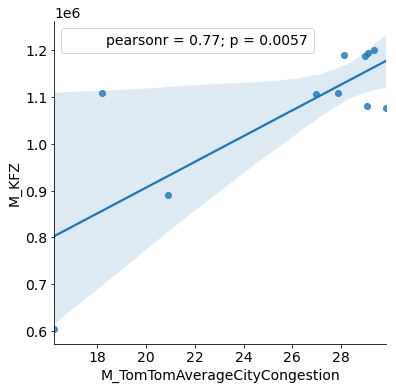

In [6]:
g = sns.JointGrid(x=df['M_TomTomAverageCityCongestion'],y=df['M_KFZ'], ratio=100)
g.plot_joint(sns.regplot)
g.annotate(stats.pearsonr)
g.ax_marg_x.set_axis_off()
g.ax_marg_y.set_axis_off()

# Estimate May and June 2020 of fuel sale based on traffic data

Not done yet
- optimization of alpha in Lasso and Ridge approach
- split in train and test set 

## Diesel

In [7]:
#choose estimator
estimator_diesel = LinearRegression()
#estimator_diesel = Ridge(alpha = 0.5)
#estimator_diesel = Lasso(alpha = 0.1)

#train
X = df.drop(['FuelSale_tons_dieselkraftstoff_sonstige','FuelSale_tons_ottokraftstoff_sonstige'],axis=1)
y = df['FuelSale_tons_dieselkraftstoff_sonstige']
estimator_diesel.fit(X,y)
y_pred = estimator_diesel.predict(X)

r2:  0.94
rmse:  45806.51
relative rmse to mean of labels:  1.54 %


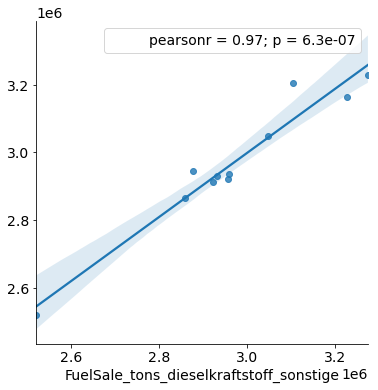

In [8]:
#validate based on training set
r2 = round(estimator_diesel.score(X, y),2)
rmse = round(np.sqrt(mean_squared_error(y, y_pred)),2)
rel_rmse = np.round(100 * rmse/y.mean(),2)
print('r2: ', r2)
print('rmse: ', rmse)
print('relative rmse to mean of labels: ', rel_rmse, '%')


g = sns.JointGrid(x=y,y=y_pred, ratio=100)
g.plot_joint(sns.regplot)
g.annotate(stats.pearsonr)
g.ax_marg_x.set_axis_off()
g.ax_marg_y.set_axis_off()

## Otto

In [9]:
#choose estimator
estimator_otto = LinearRegression()
#estimator_otto = Ridge(alpha = 0.5)
#estimator_otto = Lasso(alpha = 0.1)

#train
X = df.drop(['FuelSale_tons_dieselkraftstoff_sonstige','FuelSale_tons_ottokraftstoff_sonstige'],axis=1)
y = df['FuelSale_tons_ottokraftstoff_sonstige']
estimator_otto.fit(X,y)
y_pred = estimator_otto.predict(X)


r2:  0.94
rmse:  40100.86
relative rmse to mean of labels:  2.9 %


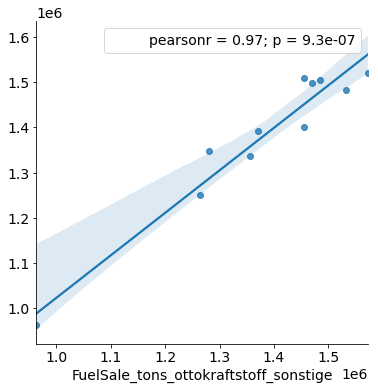

In [10]:
#validate based on training set
r2 = round(estimator_otto.score(X, y),2)
rmse = round(np.sqrt(mean_squared_error(y, y_pred)),2)
rel_rmse = np.round(100 * rmse/y.mean(),2)
print('r2: ', r2)
print('rmse: ', rmse)
print('relative rmse to mean of labels: ', rel_rmse, '%')


g = sns.JointGrid(x=y,y=y_pred, ratio=100)
g.plot_joint(sns.regplot)
g.annotate(stats.pearsonr)
g.ax_marg_x.set_axis_off()
g.ax_marg_y.set_axis_off()

## Estimate diesel and otto fuel sale for May and June 2020

In [11]:
# create feature dataframe
X_pred = pd.concat([df_TomTom, df_traffic],axis=1).dropna(axis=0)
X_pred = X_pred[X_pred.index >= '2020-05']

# estimate may and june 2020
y_pred_otto = estimator_otto.predict(X_pred)
y_pred_diesel = estimator_diesel.predict(X_pred)

#append to existing dataframe
df_tmp = pd.DataFrame({'FuelSale_tons_ottokraftstoff_sonstige': y_pred_otto,
                       'FuelSale_tons_dieselkraftstoff_sonstige': y_pred_diesel
                      }, index=['2020-05', '2020-06'])

df_fuel = pd.concat([df_diesel[['FuelSale_tons_dieselkraftstoff_sonstige']], df_otto[['FuelSale_tons_ottokraftstoff_sonstige']]],axis=1)
df_fuel = df_fuel.append(df_tmp).sort_index()


# CO2 calculation

CO2 pro Liter Kraftstoff: \
https://www.deutsche-handwerks-zeitung.de/kraftstoffverbrauch-in-co2-ausstoss-umrechnen/150/3097/57956#:~:text=Ein%20Liter%20Benzin%20entspricht%202.320,Gramm%20CO2%20angesetzt%20werden. \

Umrechnung tonnen Kraftstoff in Liter: \
1 Liter Benzin: 2.320 Gramm CO2 \
1 Liter Diesel: 2.650 Gramm CO2 



Tonnen Kraftstoff in Liter \
1 t Benzin:	1.333,33 l	\
1 t Diesel:	1.190,47 l	

In [12]:
#CO2 in kg
df_fuel['DieselCO2'] = df_fuel['FuelSale_tons_dieselkraftstoff_sonstige'] * 1190.47 * 2.65 
df_fuel['BenzinCO2'] = df_fuel['FuelSale_tons_ottokraftstoff_sonstige'] * 1333.33 * 2.32

In [13]:
df_fuel['CO2'] = df_fuel['DieselCO2'] + df_fuel['BenzinCO2']

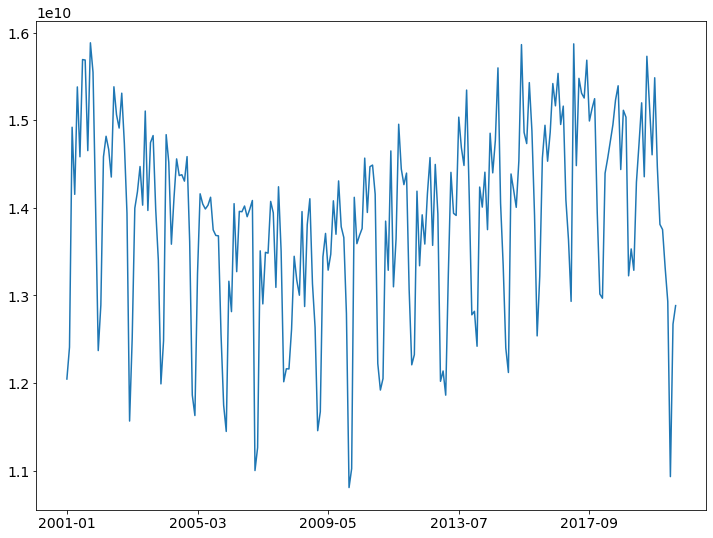

In [14]:
df_fuel['CO2'].plot(figsize=(12,9))

# Compare 2020 traffic CO2 with 2019 and 2018 traffic CO2 monthly

In [15]:
months = ['2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06']
ratio_CO2_20_19 = [df_fuel['CO2']['2020-01'] / df_fuel['CO2']['2019-01'],
                    df_fuel['CO2']['2020-02'] / df_fuel['CO2']['2019-02'],
                    df_fuel['CO2']['2020-03'] / df_fuel['CO2']['2019-03'],
                    df_fuel['CO2']['2020-04'] / df_fuel['CO2']['2019-04'],
                    df_fuel['CO2']['2020-05'] / df_fuel['CO2']['2019-05'],
                    df_fuel['CO2']['2020-06'] / df_fuel['CO2']['2019-06']
                    ]

ratio_CO2_diesel_20_19 = [df_fuel['DieselCO2']['2020-01'] / df_fuel['DieselCO2']['2019-01'],
                    df_fuel['DieselCO2']['2020-02'] / df_fuel['DieselCO2']['2019-02'],
                    df_fuel['DieselCO2']['2020-03'] / df_fuel['DieselCO2']['2019-03'],
                    df_fuel['DieselCO2']['2020-04'] / df_fuel['DieselCO2']['2019-04'],
                    df_fuel['DieselCO2']['2020-05'] / df_fuel['DieselCO2']['2019-05'],
                    df_fuel['DieselCO2']['2020-06'] / df_fuel['DieselCO2']['2019-06']
                    ]

ratio_CO2_otto_20_19 = [df_fuel['BenzinCO2']['2020-01'] / df_fuel['BenzinCO2']['2019-01'],
                    df_fuel['BenzinCO2']['2020-02'] / df_fuel['BenzinCO2']['2019-02'],
                    df_fuel['BenzinCO2']['2020-03'] / df_fuel['BenzinCO2']['2019-03'],
                    df_fuel['BenzinCO2']['2020-04'] / df_fuel['BenzinCO2']['2019-04'],
                    df_fuel['BenzinCO2']['2020-05'] / df_fuel['BenzinCO2']['2019-05'],
                    df_fuel['BenzinCO2']['2020-06'] / df_fuel['BenzinCO2']['2019-06']
                    ]


#ratio 20/18
ratio_CO2_20_18 = [df_fuel['CO2']['2020-01'] / df_fuel['CO2']['2018-01'],
                    df_fuel['CO2']['2020-02'] / df_fuel['CO2']['2018-02'],
                    df_fuel['CO2']['2020-03'] / df_fuel['CO2']['2018-03'],
                    df_fuel['CO2']['2020-04'] / df_fuel['CO2']['2018-04'],
                    df_fuel['CO2']['2020-05'] / df_fuel['CO2']['2018-05'],
                    df_fuel['CO2']['2020-06'] / df_fuel['CO2']['2018-06']
                    ]

ratio_CO2_diesel_20_18 = [df_fuel['DieselCO2']['2020-01'] / df_fuel['DieselCO2']['2018-01'],
                    df_fuel['DieselCO2']['2020-02'] / df_fuel['DieselCO2']['2018-02'],
                    df_fuel['DieselCO2']['2020-03'] / df_fuel['DieselCO2']['2018-03'],
                    df_fuel['DieselCO2']['2020-04'] / df_fuel['DieselCO2']['2018-04'],
                    df_fuel['DieselCO2']['2020-05'] / df_fuel['DieselCO2']['2018-05'],
                    df_fuel['DieselCO2']['2020-06'] / df_fuel['DieselCO2']['2018-06']
                    ]

ratio_CO2_otto_20_18 = [df_fuel['BenzinCO2']['2020-01'] / df_fuel['BenzinCO2']['2018-01'],
                    df_fuel['BenzinCO2']['2020-02'] / df_fuel['BenzinCO2']['2018-02'],
                    df_fuel['BenzinCO2']['2020-03'] / df_fuel['BenzinCO2']['2018-03'],
                    df_fuel['BenzinCO2']['2020-04'] / df_fuel['BenzinCO2']['2018-04'],
                    df_fuel['BenzinCO2']['2020-05'] / df_fuel['BenzinCO2']['2018-05'],
                    df_fuel['BenzinCO2']['2020-06'] / df_fuel['BenzinCO2']['2018-06']
                    ]


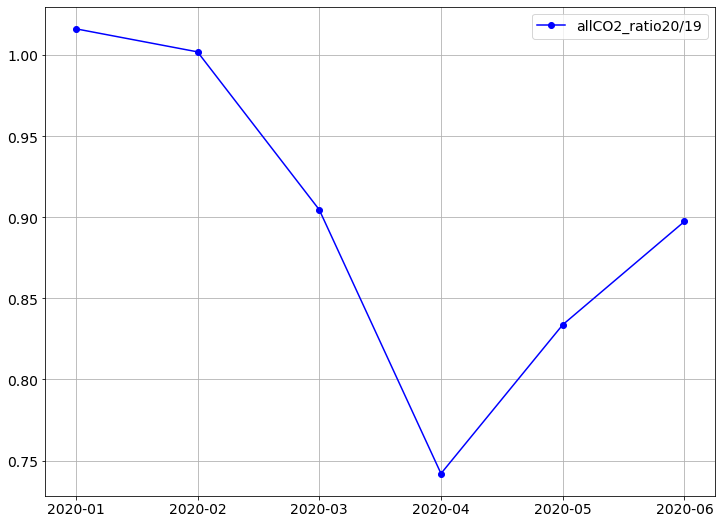

In [16]:
f, ax = plt.subplots(1, 1)
f.set_figheight(9)
f.set_figwidth(12)
ax.figsize = (12,9)
ax.plot_date(months, ratio_CO2_20_19, color="blue", label="allCO2_ratio20/19", linestyle="-")
#ax.plot_date(months, ratio_CO2_diesel_20_19, color="red", label="dieselCO2_ratio20/19", linestyle="-")
#ax.plot_date(months, ratio_CO2_otto_20_19, color="darkgreen", label="ottoCO2_ratio20/19", linestyle="-")

#ax.plot_date(months, ratio_CO2_20_18, color="black", label="allCO2_ratio20/18", linestyle="-")
#ax.plot_date(months, ratio_CO2_diesel_20_18, color="red", label="dieselCO2_ratio20/18", linestyle="-")
#ax.plot_date(months, ratio_CO2_otto_20_18, color="darkgreen", label="ottoCO2_ratio20/18", linestyle="-")

ax.grid()
ax.legend()


# Time series of traffic CO2 for Diesel and Otto fuel

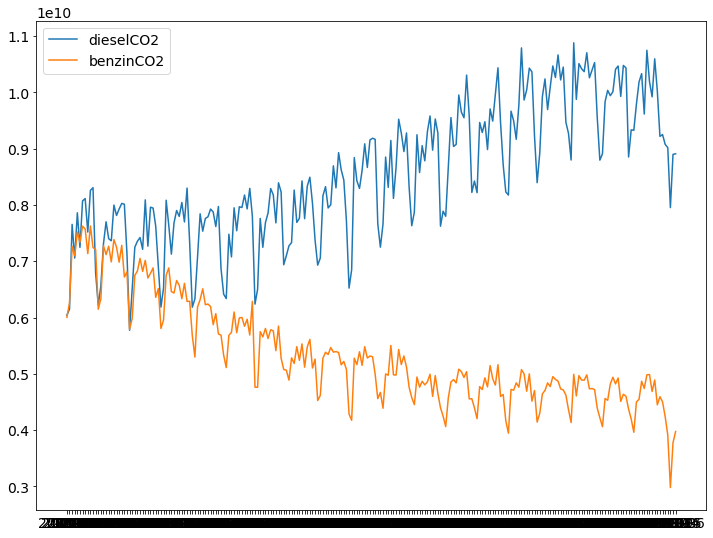

In [17]:
plt.figure(figsize=(12,9))
plt.plot(df_fuel['DieselCO2'], label='dieselCO2')
plt.plot(df_fuel['BenzinCO2'], label='benzinCO2')
plt.legend()